In [ ]:
!pip install keras-tuner

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D

from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import visualkeras
from tensorflow.keras.optimizers import Adam

from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import pickle

In [2]:
%load_ext autotime
RANDOM_STATE = 42

In [3]:
seed = 7
np.random.seed(seed)

In [4]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder+'/'+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');
    #print(f"Image shape {img.shape}")
    return img

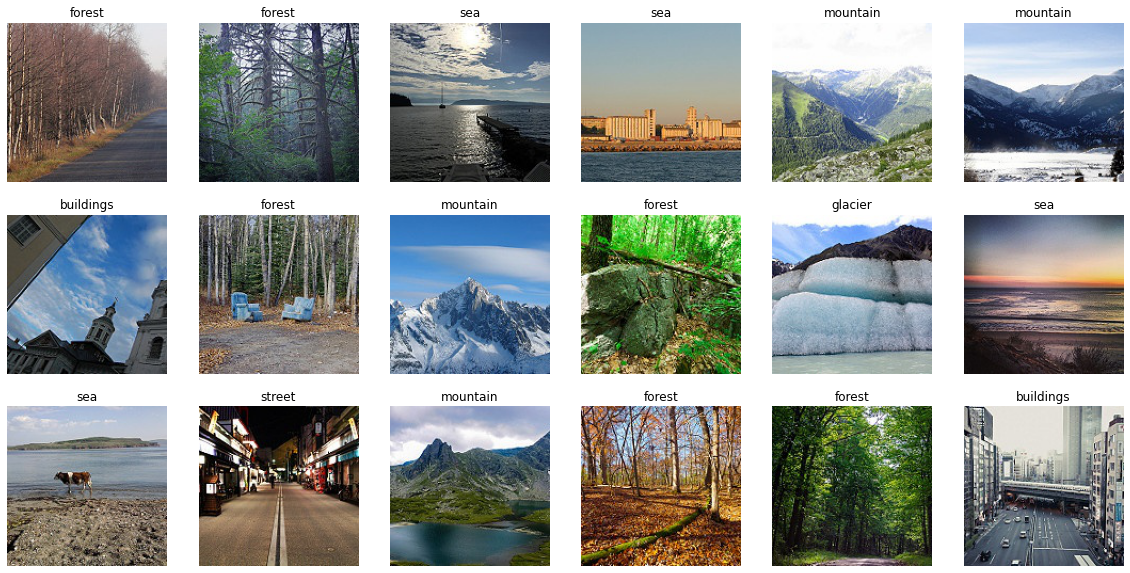

In [17]:
import random
import matplotlib.image as mpimg
from pathlib import Path
import os.path
class_names=['buildings', 'forest', 'glacier', 'mountain' ,'sea' ,'street']
plt.figure(figsize=(20, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    class_name = random.choice(class_names)
    img = view_random_image(target_dir='/home/abir/Downloads/greedyhpo/intel/archive/seg_train/seg_train/',target_class=class_name)

In [18]:
train_dir = "/home/abir/Downloads/greedyhpo/intel/archive/seg_train/seg_train"
test_dir = "/home/abir/Downloads/greedyhpo/intel/archive/seg_test/seg_test"
val_dir ="/home/abir/Downloads/greedyhpo/intel/archive/seg_val/seg_test/"

In [19]:
from keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale = 1./255)

training_data = train_data.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (32,32), 
                                              class_mode = 'categorical')

val_data = ImageDataGenerator(rescale = 1./255)

validation_data = val_data.flow_from_directory(val_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')


test_data = ImageDataGenerator(rescale = 1./255)

testing_data = test_data.flow_from_directory(test_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [20]:
LOG_DIR = f"{int(time.time())}"

In [21]:
with tf.device('/device:GPU:1'):

    def build_model(hp):

        model = Sequential()
        model.add(Conv2D(hp.Choice('layer_size_1', values=[16,32,64,128,256,512],default=16), 3, activation='relu', padding = 'same', input_shape=(32, 32, 3),kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(Dropout(hp.Choice('dp_size_1', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)))
        model.add(Conv2D(hp.Choice('layer_size_1', values=[16,32,64,128,256,512],default=16), 3, activation='relu', padding = 'same',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        #####################################Block 2#################################         
        model.add(Conv2D(hp.Choice('layer_size_2', values=[16,32,64,128,256,512],default=16), 3,padding ='same', activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(Dropout(hp.Choice('dp_size_2', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)))
        model.add(Conv2D(hp.Choice('layer_size_2', values=[16,32,64,128,256,512],default=16), 3,padding ='same', activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        ######################################Block 3#################################            
        model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(Dropout(hp.Choice('dp_size_3', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)))
        model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(Dropout(hp.Choice('dp_size_3', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)))
        model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        ######################################Block 4################################
        model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(Dropout(hp.Choice('dp_size_4', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)))
        model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(Dropout(hp.Choice('dp_size_4', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)))
        model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        ######################################Block 5#################################
        model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(Dropout(hp.Choice('dp_size_5', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)))
        model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(Dropout(hp.Choice('dp_size_5', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)))
        model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        ############################################################################
        model.add(Dropout(hp.Choice('dp_size_6', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)))
        model.add(Flatten())
        model.add(Dense(hp.Choice('dense_size_1', values=[64,128,256,512],default=64),activation="relu",kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(Dense(hp.Choice('dense_size_2', values=[64,128,256,512],default=64),activation="relu",kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
        model.add(Dropout(hp.Choice('dp_size_6', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)))
        model.add(Dense(units=6, activation="softmax"))
     ##############################################################################           

        opt = Adam(lr=hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3, 1e-4, 1e-5],default=1e-2))

        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                                      optimizer=opt,
                                                      metrics=['accuracy'])
        return model

In [22]:
with tf.device('/device:GPU:1'):
    tuner = BayesianOptimization(
        build_model,
        objective='val_accuracy',
        max_trials=87,  # how many model variations to test?
        executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
        directory=LOG_DIR,
        project_name='BS_Vgg16_Intel10')

    tuner.search_space_summary()
    my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3)]
    tuner.search(training_data,
                 verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
                 epochs=100,
                 batch_size=64,
                 callbacks=[my_callbacks],  # if you have callbacks like tensorboard, they go here.
                 validation_data=validation_data)

    tuner.results_summary()

    with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
        pickle.dump(tuner, f)

Trial 87 Complete [00h 02m 12s]
val_accuracy: 0.3816666603088379

Best val_accuracy So Far: 0.8529166579246521
Total elapsed time: 06h 28m 20s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in 1624984620/BS_Vgg16_Intel10
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layer_size_1: 512
wd_size_1: 0.0001
dp_size_1: 0.0
layer_size_2: 512
dp_size_2: 0.0
layer_size_3: 512
dp_size_3: 0.3
layer_size_4: 512
dp_size_4: 0.0
layer_size_5: 512
dp_size_5: 0.7
dp_size_6: 0.4
dense_size_1: 512
dense_size_2: 64
learning_rate: 1e-05
Score: 0.8529166579246521
Trial summary
Hyperparameters:
layer_size_1: 512
wd_size_1: 0.0001
dp_size_1: 0.0
layer_size_2: 512
dp_size_2: 0.0
layer_size_3: 512
dp_size_3: 0.4
layer_size_4: 512
dp_size_4: 0.4
layer_size_5: 512
dp_size_5: 0.2
dp_size_6: 0.0
dense_size_1: 512
dense_size_2: 64
learning_rate: 1e-05
Score: 0.8366666436195374
Trial summary
Hyperparameters:
layer_size_1: 512
wd_size_1: 0.0001
dp_s

In [23]:
new_model = tuner.get_best_hyperparameters()[0]

In [24]:
model = tuner.hypermodel.build(new_model)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 512)       14336     
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 512)       2359808   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 512)       2359808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 512)       2

In [26]:
with tf.device('/device:GPU:1'):
    hist=model.fit(training_data,
          batch_size=64,
          epochs=100,
          validation_data=validation_data,
          callbacks=[my_callbacks])

Epoch 1/100


ValueError: Expect x to be a non-empty array or dataset.

In [27]:
_,test_acc = model.evaluate(testing_data[0][0],testing_data[0][1])

1/1 [==============================] - 2s 2s/step - loss: 2.4691 - accuracy: 78.1646
